In [38]:
import pandas as pd
#Analyze San Francisco International Airport (SFO) Operations dataset to determine the 
#probability of Arrivals (A) vs. Departures (D) by the Runway to plan for operational and logistical efficiency
#DATASET: https://data.sfgov.org/Transportation/SFO-Flight-Operations/43zc-xw3x/about_data

# Load dataset
df = pd.read_csv('/Users/kdorion/Documents/MSAE/2024/Fall_2024/ECON611/FINAL PROJECT/SFO_Flight_Operations.csv')

#see column names and distinct values in columns most likely holding data to determine the probability of arrivals/departures
print(df.columns)
print(df['runway_name'].unique())
print(df['operation_type'].unique())
#operation type -->  A=Arrival, D=Departure, O=Overflight, G=Ground, T=Touch&Go (as defined by data dictionary)

Index(['unique_identifier', 'operation_no', 'flight_date_time', 'year',
       'month', 'hour', 'corr_id', 'operation_type', 'runway_name',
       'aircraft_type', 'aircraft_category', 'airline', 'other_port',
       'airport_code', 'gate_penetration', 'gate_name',
       'gate_penetration_time', 'altitude', 'center_deviation', 'flight_no',
       'tail_number', 'data_as_of', 'data_loaded_at'],
      dtype='object')
['01L' '01R' '28L' '28R' '10L' '19L' nan 'HELI' 'HCIV' 'HMIL' '10R' '19R'
 'H' '30L' 'NONE' '32R' '25R' '12']
['D' 'A' 'G' 'T' 'O']


In [40]:
# Filter relevant columns: runway_name, operation_type
runway_data = df[['runway_name', 'operation_type']]

# Drop rows with missing or irrelevant data
runway_data.dropna(inplace=True)

# MORE EXPLORATORY INFO: Display basic info and preview
print(runway_data.info())
print(runway_data.head())
print(runway_data.tail())

<class 'pandas.core.frame.DataFrame'>
Index: 1922523 entries, 0 to 1925946
Data columns (total 2 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   runway_name     object
 1   operation_type  object
dtypes: object(2)
memory usage: 44.0+ MB
None
  runway_name operation_type
0         01L              D
1         01R              D
2         01R              D
3         01R              D
4         28L              A
        runway_name operation_type
1925942         10L              D
1925943         10L              D
1925944         19L              A
1925945         10L              D
1925946         19L              A


/var/folders/6j/pmgy91ns295gxlfrv0dz53bmt6tjzs/T/ipykernel_55072/3402195585.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runway_data.dropna(inplace=True)


In [42]:
# Count operations by runway and operation type
ops_counts = runway_data.groupby(['runway_name', 'operation_type']).size().reset_index(name='count')

# Total operations per runway
total_counts = ops_counts.groupby('runway_name')['count'].sum().reset_index(name='total_operations')

# Merge total counts back into operation counts
ops_counts = ops_counts.merge(total_counts, on='runway_name')
ops_counts['probability'] = ops_counts['count'] / ops_counts['total_operations']

# Display results
print(ops_counts)

   runway_name operation_type   count  total_operations  probability
0          01L              A      10            227295     0.000044
1          01L              D  227219            227295     0.999666
2          01L              O       1            227295     0.000004
3          01L              T      65            227295     0.000286
4          01R              A     209            361828     0.000578
5          01R              D  361526            361828     0.999165
6          01R              T      93            361828     0.000257
7          10L              A     947             21248     0.044569
8          10L              D   20292             21248     0.955008
9          10L              T       9             21248     0.000424
10         10R              A     342              9563     0.035763
11         10R              D    9220              9563     0.964133
12         10R              T       1              9563     0.000105
13          12              D     

In [44]:
# Aggregate probabilities for arrivals and departures
ops_summary = ops_counts.pivot(index='runway_name', columns='operation_type', values='probability').fillna(0)

# Add a total usage column
ops_summary['total_probability'] = ops_summary.sum(axis=1)

# Display the runway utilization probabilities
print(ops_summary)

operation_type         A         D         G         O         T  \
runway_name                                                        
01L             0.000044  0.999666  0.000000  0.000004  0.000286   
01R             0.000578  0.999165  0.000000  0.000000  0.000257   
10L             0.044569  0.955008  0.000000  0.000000  0.000424   
10R             0.035763  0.964133  0.000000  0.000000  0.000105   
12              0.000000  1.000000  0.000000  0.000000  0.000000   
19L             0.988343  0.011657  0.000000  0.000000  0.000000   
19R             0.434328  0.565417  0.000000  0.000000  0.000255   
25R             0.000000  1.000000  0.000000  0.000000  0.000000   
28L             0.735108  0.264837  0.000000  0.000000  0.000055   
28R             0.903285  0.096618  0.000000  0.000000  0.000096   
30L             1.000000  0.000000  0.000000  0.000000  0.000000   
32R             1.000000  0.000000  0.000000  0.000000  0.000000   
H               0.434343  0.565657  0.000000  0.

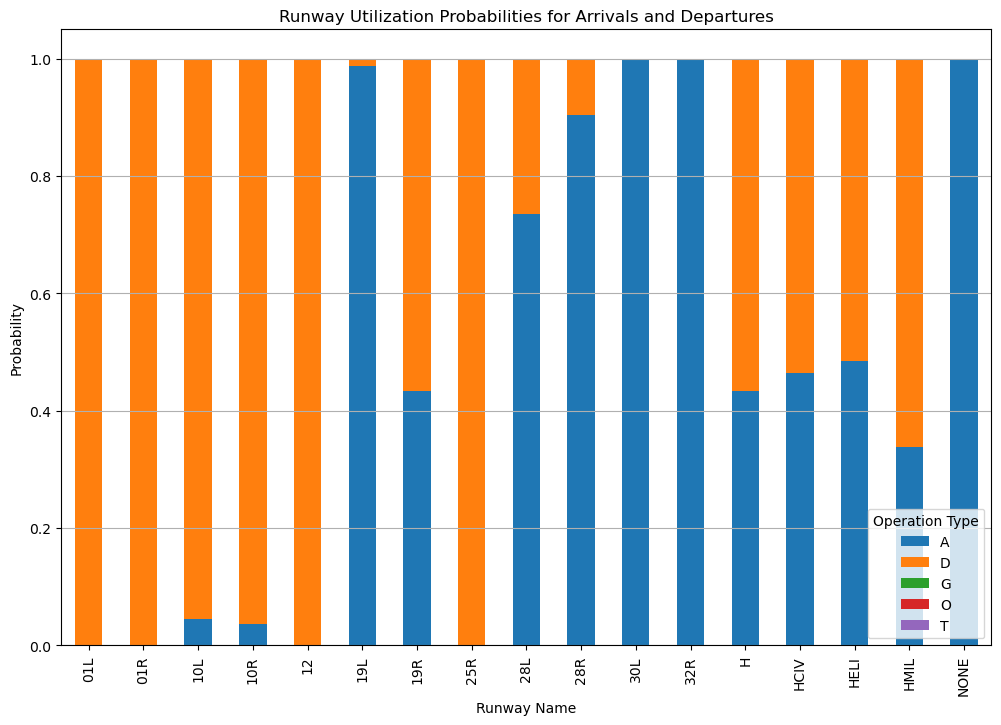

In [86]:
import matplotlib.pyplot as plt

# Bar chart without total_probability
ops_summary.drop(columns=['total_probability'], errors='ignore').plot(
    kind='bar',
    figsize=(12, 8),
    stacked=True 
)
plt.title('Runway Utilization Probabilities for Arrivals and Departures')
plt.xlabel('Runway Name')
plt.ylabel('Probability')
plt.legend(title='Operation Type')
plt.grid(axis='y')
plt.show()

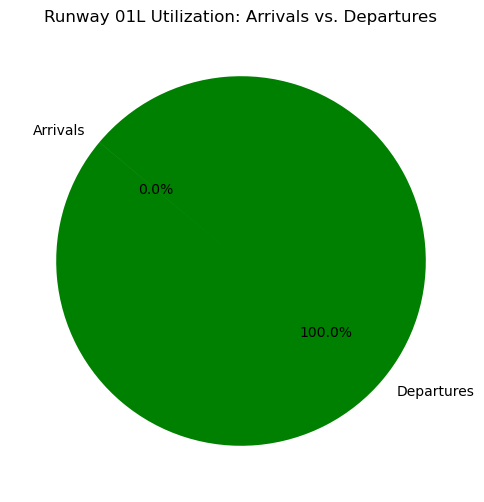

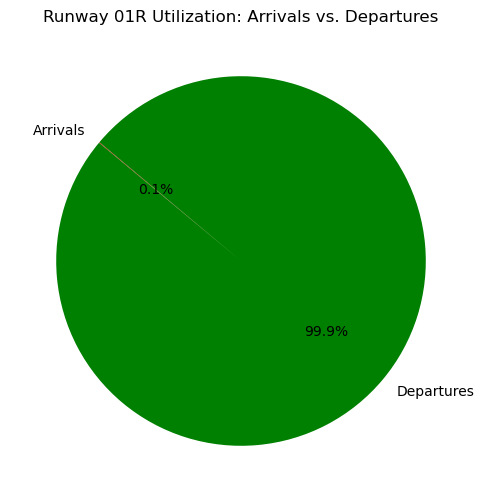

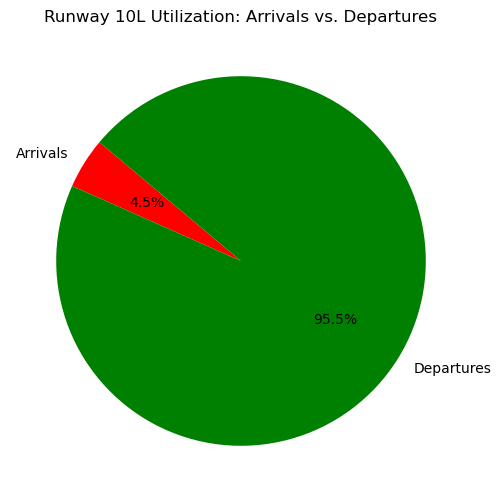

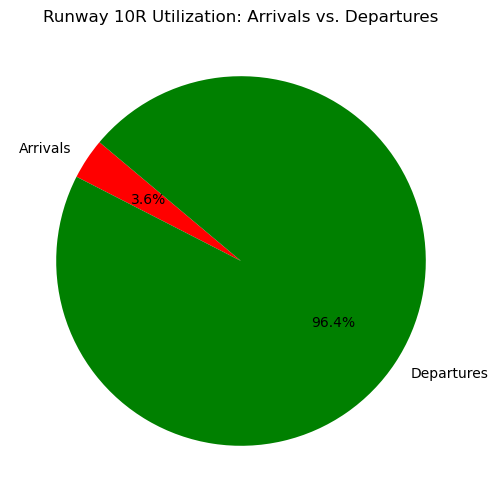

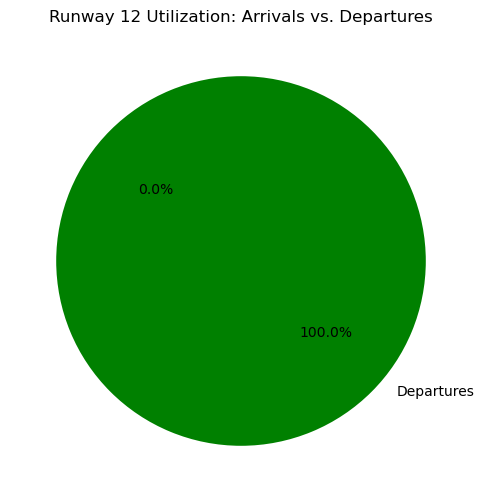

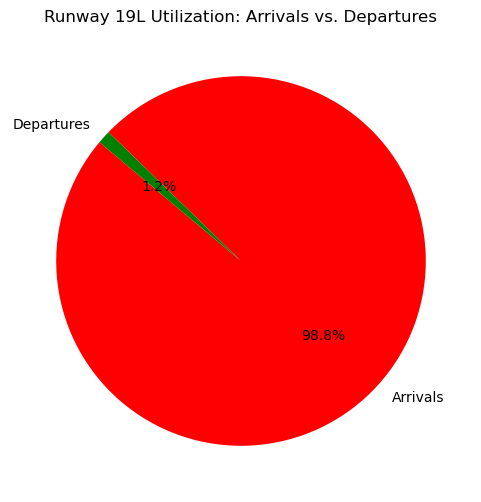

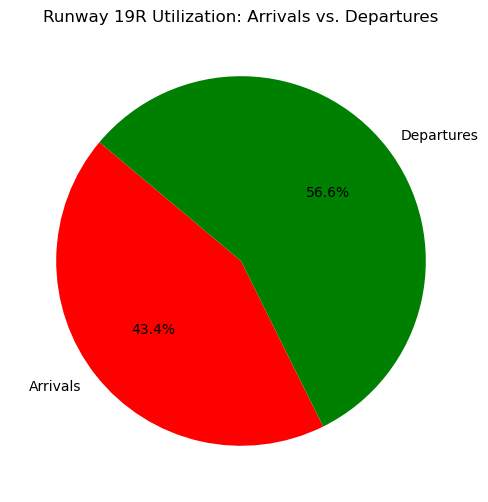

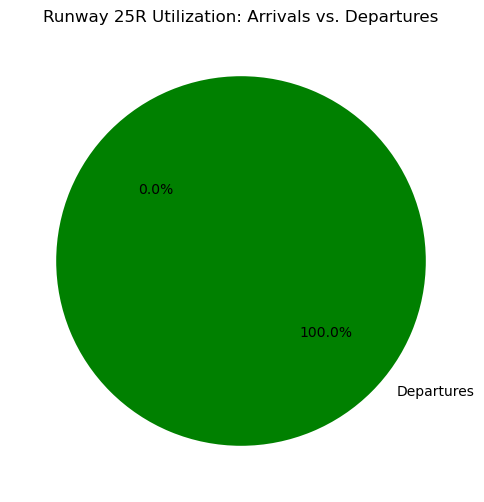

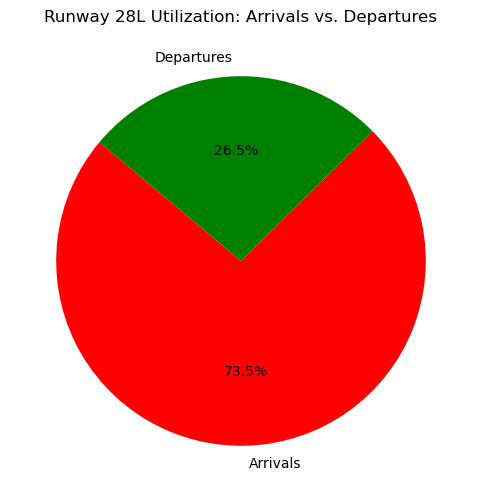

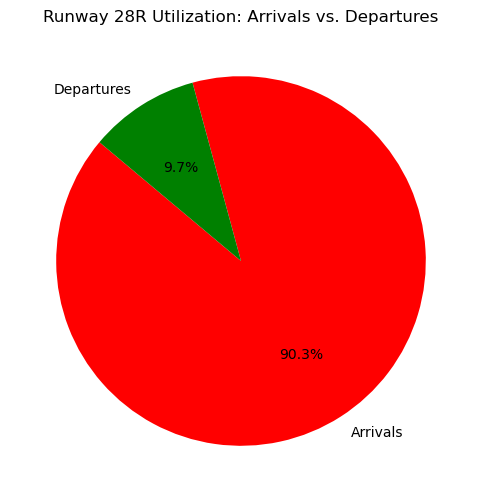

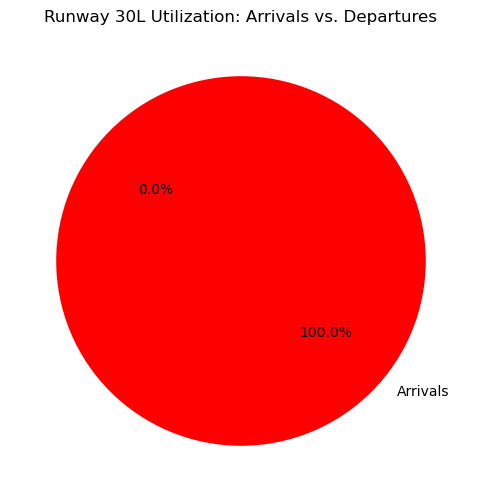

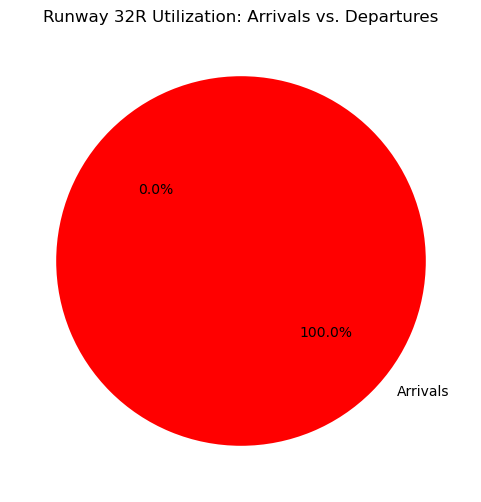

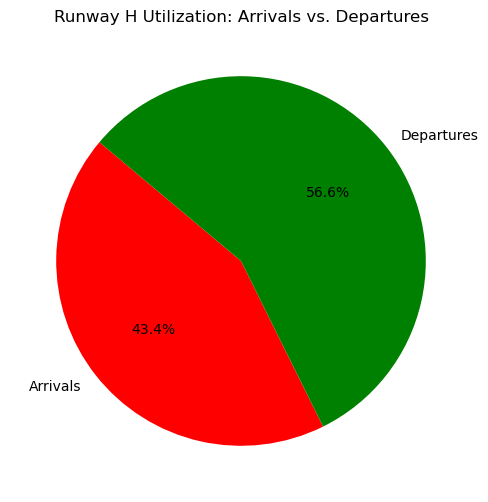

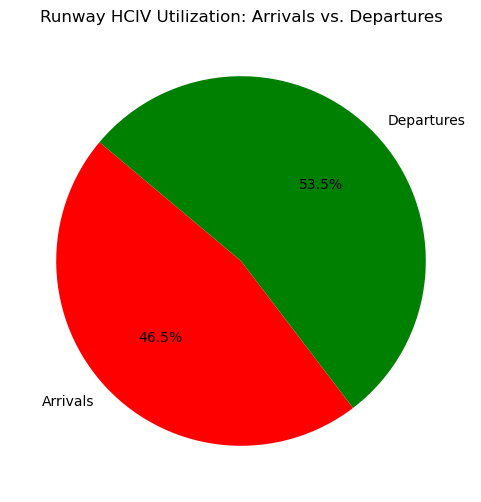

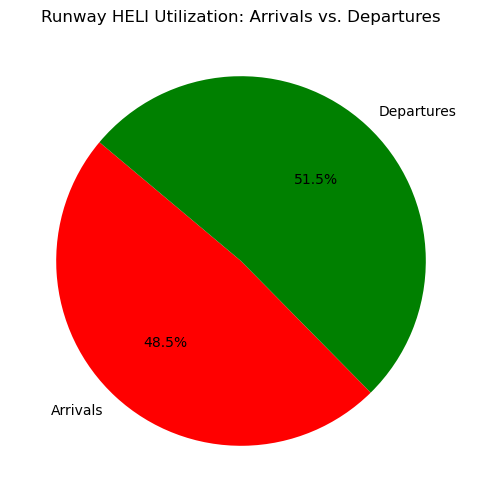

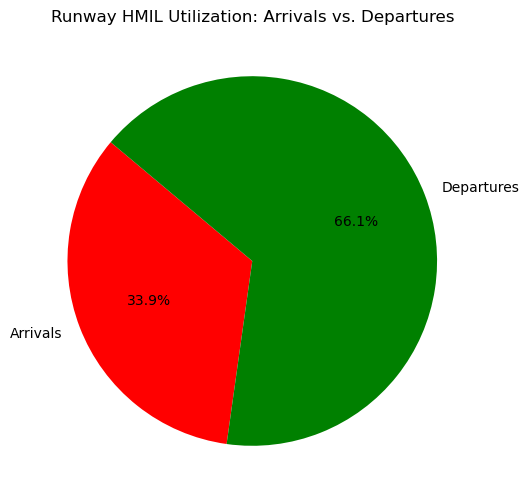

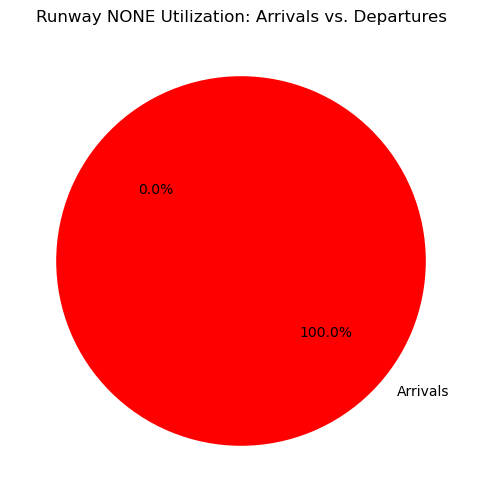

In [108]:
# Generate individual pie charts for each runway
for runway in ops_summary.index:
    # Extract probabilities for the runway
    runway_data = ops_summary.loc[runway][['A', 'D']]  # 'A' = Arrivals, 'D' = Departures
    runway_data.plot(
        kind='pie',
        autopct='%1.1f%%',
        startangle=140,
        figsize=(6, 6),
        labels=['Arrivals', 'Departures'],
        colors=['red', 'green']
    )
    plt.title(f'Runway {runway} Utilization: Arrivals vs. Departures')
    plt.ylabel('')  # Remove default y-axis label
    plt.show()